differential_evolution step 1: f(x)= -244.0
differential_evolution step 2: f(x)= -246.0
differential_evolution step 3: f(x)= -246.0
differential_evolution step 4: f(x)= -246.0
differential_evolution step 5: f(x)= -256.0
differential_evolution step 6: f(x)= -256.0
differential_evolution step 7: f(x)= -257.0
differential_evolution step 8: f(x)= -257.0
differential_evolution step 9: f(x)= -257.0
differential_evolution step 10: f(x)= -257.0
differential_evolution step 11: f(x)= -267.0
differential_evolution step 12: f(x)= -267.0
differential_evolution step 13: f(x)= -267.0
differential_evolution step 14: f(x)= -267.0
differential_evolution step 15: f(x)= -267.0
differential_evolution step 16: f(x)= -267.0
differential_evolution step 17: f(x)= -267.0
differential_evolution step 18: f(x)= -267.0
differential_evolution step 19: f(x)= -267.0
differential_evolution step 20: f(x)= -267.0
differential_evolution step 21: f(x)= -267.0
differential_evolution step 22: f(x)= -267.0
differential_evolut

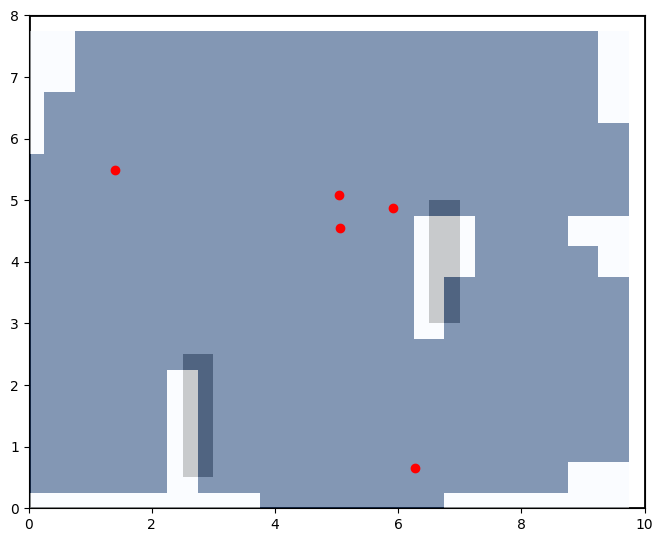


Running blocking verification test...
Success: Sensor correctly blocked by obstacle.


In [4]:
# ======================================================================
# SCRIPT TITLE: Directional PIR Sensor Placement Optimization using DE
# ======================================================================
#
# PURPOSE:
# This script optimizes the placement of directional Passive Infrared (PIR) sensors
# in a 2D room with obstacles using **Differential Evolution (DE)**.
# The goal is to **maximize sensor coverage**, taking into account:
#  - Room boundaries
#  - Rectangular obstacles (e.g., cabinets)
#  - Sensor detection range
#  - Sensor directional Field-of-View (FOV)
#  - Line-of-sight (LoS) checks to prevent “seeing through walls”
#
# METHODOLOGY:
# 1. The room is discretized into a grid of cells (0.5m resolution).
# 2. Each sensor has parameters: (x, y, orientation).
# 3. Coverage is computed per cell:
#     a) Cell is within room
#     b) Cell is not inside an obstacle
#     c) Cell is within sensor range
#     d) Cell is within sensor FOV
#     e) LoS to cell is not blocked by any obstacle
# 4. Differential Evolution searches for the sensor parameters that maximize total coverage.
#
# PARAMETERS:
# - Room size: 10m x 8m
# - Sensor count: 5
# - Sensor detection range: 5m
# - Sensor FOV: 100 degrees
# - Obstacles: two rectangular cabinets
# - DE settings: 300 iterations, 30 population size
#
# OUTPUTS:
# - Optimal sensor positions and orientations
# - Coverage map visualization
# - Verification that sensors do not see through obstacles
#
# DEPENDENCIES:
# numpy, matplotlib, scipy, math
# ======================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import math

# ---------------- Helper Function ----------------
def is_angle_in_range(angle, start_angle, end_angle):
    """
    Checks if 'angle' is within [start_angle, end_angle], accounting for wrap-around.
    All angles are in radians (-pi to pi).
    """
    angle = (angle + 2*math.pi) % (2*math.pi)
    start_angle = (start_angle + 2*math.pi) % (2*math.pi)
    end_angle = (end_angle + 2*math.pi) % (2*math.pi)
    if start_angle <= end_angle:
        return start_angle <= angle <= end_angle
    else:
        return angle >= start_angle or angle <= end_angle

# ---------------- Room & Sensor Classes ----------------
class Room:
    """
    Represents a 2D room with rectangular obstacles.
    Provides methods for checking:
    - Whether a point is inside the room
    - Whether a point is inside any obstacle
    - Whether a line between two points is obstructed
    """
    def __init__(self, width, height, obstacles=None):
        self.width = width
        self.height = height
        self.obstacles = obstacles if obstacles else []
        self.grid_resolution = 0.5
        self.grid_x = int(self.width/self.grid_resolution)
        self.grid_y = int(self.height/self.grid_resolution)
        self.coverage_grid = np.zeros((self.grid_x, self.grid_y))

    def is_inside(self, x, y):
        return 0 <= x <= self.width and 0 <= y <= self.height

    def is_obstructed_at_point(self, x, y):
        for ox, oy, ow, oh in self.obstacles:
            if ox <= x <= ox+ow and oy <= y <= oy+oh:
                return True
        return False

    def is_line_obstructed(self, p1, p2, step_size=0.1):
        """
        Returns True if a line segment between p1 and p2 is blocked by any obstacle.
        Uses discrete steps along the line (ray-casting approach).
        """
        dist = np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
        if dist == 0:
            return self.is_obstructed_at_point(p1[0], p1[1])
        steps = int(dist/step_size)+1
        for i in range(steps):
            t = i/steps
            px = p1[0] + t*(p2[0]-p1[0])
            py = p1[1] + t*(p2[1]-p1[1])
            if self.is_obstructed_at_point(px, py):
                return True
        return False

class Sensor:
    """
    Represents a directional PIR sensor.
    - Computes which grid cells are covered based on:
      range, FOV, orientation, and obstacle blocking.
    """
    def __init__(self, x, y, detection_range, orientation_deg, fov_deg):
        self.x = x
        self.y = y
        self.detection_range = detection_range
        self.orientation = math.radians(orientation_deg)
        self.fov = math.radians(fov_deg)

    def get_covered_points(self, room):
        covered = []
        sensor_pos = (self.x, self.y)
        if room.is_obstructed_at_point(self.x, self.y):
            return covered
        half_fov = self.fov / 2
        min_angle = self.orientation - half_fov
        max_angle = self.orientation + half_fov
        for gx in range(room.grid_x):
            for gy in range(room.grid_y):
                px = gx*room.grid_resolution + room.grid_resolution/2
                py = gy*room.grid_resolution + room.grid_resolution/2
                if not room.is_inside(px, py): continue
                if room.is_obstructed_at_point(px, py): continue
                distance = np.sqrt((self.x-px)**2 + (self.y-py)**2)
                if distance > self.detection_range: continue
                angle_to_point = math.atan2(py-self.y, px-self.x)
                if not is_angle_in_range(angle_to_point, min_angle, max_angle): continue
                if not room.is_line_obstructed(sensor_pos, (px, py)):
                    covered.append((gx, gy))
        return covered

# ---------------- Objective Function ----------------
ROOM_WIDTH = 10
ROOM_HEIGHT = 8
NUM_SENSORS = 5
SENSOR_DETECTION_RANGE = 5.0
PIR_FOV_DEGREES = 100
ROOM_OBSTACLES = [(2.5,0.5,0.5,2.0),(6.5,3.0,0.5,2.0)]
ROOM_OBJ = Room(ROOM_WIDTH, ROOM_HEIGHT, ROOM_OBSTACLES)

def calculate_coverage(sensor_params):
    grid = np.zeros_like(ROOM_OBJ.coverage_grid)
    sensors = []
    for i in range(NUM_SENSORS):
        x, y, ori = sensor_params[3*i:3*i+3]
        sensors.append(Sensor(x, y, SENSOR_DETECTION_RANGE, math.degrees(ori), PIR_FOV_DEGREES))
    total = 0
    for s in sensors:
        for gx, gy in s.get_covered_points(ROOM_OBJ):
            if grid[gx, gy] == 0:
                grid[gx, gy] = 1
                total += 1
    return total

def objective_function(sensor_params):
    return -calculate_coverage(sensor_params)

# ---------------- Differential Evolution ----------------
bounds = []
for _ in range(NUM_SENSORS):
    bounds.extend([(0, ROOM_WIDTH), (0, ROOM_HEIGHT), (0, 2*math.pi)])

result = differential_evolution(objective_function, bounds, strategy='best1bin',
                                maxiter=300, popsize=30, tol=0.01, disp=True)
optimal_params = result.x
optimal_coverage = -result.fun
print(f"\nOptimal Covered Cells: {optimal_coverage}")

# ---------------- Visualization ----------------
def plot_room_and_coverage(room, sensors_data):
    fig, ax = plt.subplots(figsize=(room.width*0.8, room.height*0.8))
    ax.add_patch(plt.Rectangle((0,0),room.width,room.height,fill=False,edgecolor='black',linewidth=2))
    for ox, oy, ow, oh in room.obstacles:
        ax.add_patch(plt.Rectangle((ox,oy),ow,oh,facecolor='gray',alpha=0.8))
    coverage_map = np.zeros((room.grid_x, room.grid_y))
    for x, y, ori in sensors_data:
        sensor = Sensor(x, y, SENSOR_DETECTION_RANGE, math.degrees(ori), PIR_FOV_DEGREES)
        for gx, gy in sensor.get_covered_points(room):
            coverage_map[gx, gy] = 1
        ax.plot(x, y, 'ro')
    x_coords = np.arange(0, room.width, room.grid_resolution)
    y_coords = np.arange(0, room.height, room.grid_resolution)
    plt.pcolormesh(x_coords, y_coords, coverage_map.T, cmap='Blues', alpha=0.5, shading='auto')
    ax.set_xlim(0, room.width); ax.set_ylim(0, room.height)
    ax.set_aspect('equal')
    plt.show()

plot_room_and_coverage(ROOM_OBJ, optimal_params.reshape(NUM_SENSORS,3))

# ---------------- Verification Test ----------------
def test_sensor_blocking(room):
    print("\nRunning blocking verification test...")
    sensor = Sensor(3.0, 1.0, SENSOR_DETECTION_RANGE, 90, PIR_FOV_DEGREES)
    points = sensor.get_covered_points(room)
    if points:
        print("Warning: Sensor sees through obstacle!")
    else:
        print("Success: Sensor correctly blocked by obstacle.")

test_sensor_blocking(ROOM_OBJ)



In [5]:
import math
import numpy as np

# Assuming your DE result is stored in 'result'
optimal_sensor_params = result.x  # This is the flat array of optimal values
num_sensors = 5  # Adjust to your number of sensors

# Reshape into (num_sensors x 3) for easier reading: [x, y, orientation_rad]
optimal_sensors = optimal_sensor_params.reshape(num_sensors, 3)

print("\n--- Differential Evolution Optimal Sensor Placement ---")
print("Sensor # |      X (m) |      Y (m) | Orientation (deg)")
print("------------------------------------------------------")
for i, (x, y, ori_rad) in enumerate(optimal_sensors, start=1):
    ori_deg = math.degrees(ori_rad)  # Convert radians to degrees
    print(f"{i:7d} | {x:10.3f} | {y:10.3f} | {ori_deg:14.2f}")


--- Differential Evolution Optimal Sensor Placement ---
Sensor # |      X (m) |      Y (m) | Orientation (deg)
------------------------------------------------------
      1 |      5.908 |      4.873 |         232.07
      2 |      6.273 |      0.653 |          52.23
      3 |      1.405 |      5.485 |         266.05
      4 |      5.048 |      4.549 |         136.36
      5 |      5.032 |      5.088 |          48.31
